In [50]:
!pip install wordcloud
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [51]:
tweets = pd.read_csv('sentiment_tweets3.csv')
#tweets.head(20)

In [52]:
tweets.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [53]:
tweets['label'].value_counts()

0    8000
1    2314
Name: label, dtype: int64

In [54]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 2 columns):
message    10314 non-null object
label      10314 non-null int64
dtypes: int64(1), object(1)
memory usage: 161.3+ KB


In [55]:
totalTweets = 8000 + 2314
trainIndex, testIndex = list(), list()
for i in range(tweets.shape[0]):
    if np.random.uniform(0, 1) < 0.98:
        trainIndex += [i]
    else:
        testIndex += [i]
trainData = tweets.iloc[trainIndex]
testData = tweets.iloc[testIndex]

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweets['message'],tweets['label'],test_size=0.1, random_state=1337)

In [57]:
X_test.shape

(1032,)

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,2))

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

In [60]:
test_vectors

<1032x2522 sparse matrix of type '<class 'numpy.float64'>'
	with 11572 stored elements in Compressed Sparse Row format>

In [61]:
trainData['label'].value_counts()

0    7828
1    2281
Name: label, dtype: int64

In [62]:
trainData.head()

,message,label
0,"just had a real good moment. i missssssssss him so much,",0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zoGfqvh2ME8,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
5,so sleepy. good times tonight though,0


In [63]:
testData['label'].value_counts()

0    172
1     33
Name: label, dtype: int64

In [64]:
testData.head()

,message,label
3,"@lapcat Need to send 'em to my accountant tomorrow. Oddly, I wasn't even referring to my taxes. Those are supporting evidence, though.",0
20,haven't been able to sleep at ALL. i think i'll watch Ugly Betty online.,0
22,@aidenchan yeah sure but its my sister's so take EXTRA gd care,0
29,NIGHT babies. Got a VH1 thing in the am Check out my pics! http://twitpic.com/2y57u http://twitpic.com/2xzl1 http://twitpic.com/2y5s2,0
30,got the magic numbers and is thanking y'all for the support,0


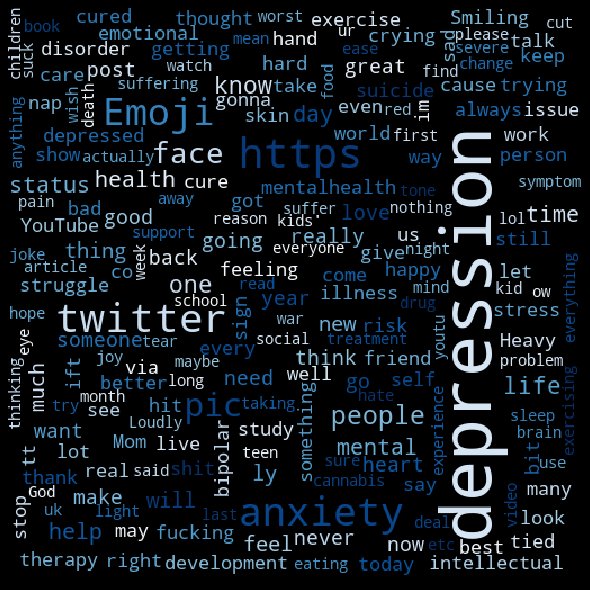

In [65]:
depressive_words = ' '.join(list(tweets[tweets['label'] == 1]['message']))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

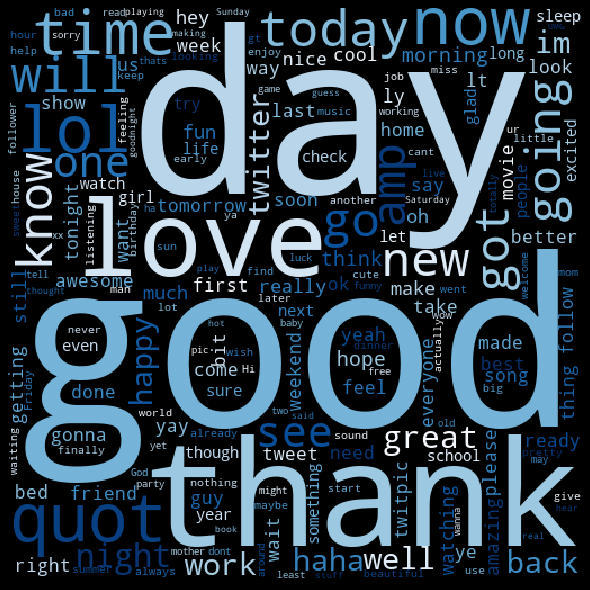

In [66]:
positive_words = ' '.join(list(tweets[tweets['label'] == 0]['message']))
positive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(positive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(positive_wc)
plt.axis('off'), 
plt.tight_layout(pad = 0)
plt.show()

In [67]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower() 
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [68]:
class TweetClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.tweets, self.labels = trainData['message'], trainData['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word] + 1) / (self.depressive_words + \
                                                                len(list(self.tf_depressive.keys())))
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word] + 1) / (self.positive_words + \
                                                                len(list(self.tf_positive.keys())))
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 


    def calc_TF_and_IDF(self):
        noOfMessages = self.tweets.shape[0]
        self.depressive_tweets, self.positive_tweets = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_tweets = self.depressive_tweets + self.positive_tweets
        self.depressive_words = 0
        self.positive_words = 0
        self.tf_depressive = dict()
        self.tf_positive = dict()
        self.idf_depressive = dict()
        self.idf_positive = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.tweets.iloc[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels.iloc[i]:
                    self.tf_depressive[word] = self.tf_depressive.get(word, 0) + 1
                    self.depressive_words += 1
                else:
                    self.tf_positive[word] = self.tf_positive.get(word, 0) + 1
                    self.positive_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels.iloc[i]:
                    self.idf_depressive[word] = self.idf_depressive.get(word, 0) + 1
                else:
                    self.idf_positive[word] = self.idf_positive.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        self.sum_tf_idf_depressive = 0
        self.sum_tf_idf_positive = 0
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive[word] + self.idf_positive.get(word, 0)))
            self.sum_tf_idf_depressive += self.prob_depressive[word]
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.prob_depressive[word] + 1) / (self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
            
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive.get(word, 0) + self.idf_positive[word]))
            self.sum_tf_idf_positive += self.prob_positive[word]
        for word in self.tf_positive:
            self.prob_positive[word] = (self.prob_positive[word] + 1) / (self.sum_tf_idf_positive + len(list(self.prob_positive.keys())))
            
    
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 
                    
    def classify(self, processed_message):
        pDepressive, pPositive = 0, 0
        for word in processed_message:                
            if word in self.prob_depressive:
                pDepressive += log(self.prob_depressive[word])
            else:
                if self.method == 'tf-idf':
                    pDepressive -= log(self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
                else:
                    pDepressive -= log(self.depressive_words + len(list(self.prob_depressive.keys())))
            if word in self.prob_positive:
                pPositive += log(self.prob_positive[word])
            else:
                if self.method == 'tf-idf':
                    pPositive -= log(self.sum_tf_idf_positive + len(list(self.prob_positive.keys()))) 
                else:
                    pPositive -= log(self.positive_words + len(list(self.prob_positive.keys())))
            pDepressive += log(self.prob_depressive_tweet)
            pPositive += log(self.prob_positive_tweet)
        return pDepressive >= pPositive
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result

In [69]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels.iloc[i] == 1 and predictions[i] == 1)
        true_neg += int(labels.iloc[i] == 0 and predictions[i] == 0)
        false_pos += int(labels.iloc[i] == 0 and predictions[i] == 1)
        false_neg += int(labels.iloc[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [70]:
sc_tf_idf = TweetClassifier(trainData, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['message'])
metrics(testData['label'], preds_tf_idf)

Precision:  0.9523809523809523
Recall:  0.6060606060606061
F-score:  0.7407407407407407
Accuracy:  0.9317073170731708


In [71]:
sc_bow = TweetClassifier(trainData, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(testData['message'])
metrics(testData['label'], preds_bow)

Precision:  0.9166666666666666
Recall:  0.3333333333333333
F-score:  0.4888888888888888
Accuracy:  0.8878048780487805


In [23]:
!pip install wordcloud
!pip install nltk
import nltk
#nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from math import log, sqrt
import re    # for regular expressions 
import nltk  # for text manipulation 
import string # for text manipulation 
import warnings 
import numpy as np 
import pandas as pd # for data manipulation 
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore") #ignore warnings

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
data = pd.read_csv("dataset.csv",encoding='latin-1')
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [25]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "TweetText"]
data.columns = DATASET_COLUMNS
data.head()

,target,ids,date,flag,user,TweetText
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [26]:
data.drop(['ids','date','flag','user'],axis = 1,inplace = True)

In [27]:
data.head()

,target,TweetText
0,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,@Kwesidei not the whole crew


In [28]:
positif_data = data[data.target==4].iloc[:25000,:]
print(positif_data.shape)
negative_data = data[data.target==0].iloc[:1000,:]
print(negative_data.shape)

(25000, 2)
(1000, 2)


In [29]:
data = pd.concat([positif_data,negative_data],axis = 0)
print(data.shape)
data.head()

(26000, 2)


,target,TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!
800000,4,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart."
800002,4,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup"
800003,4,@LovesBrooklyn2 he has that effect on everyone


In [30]:
data['Clean_TweetText'] = data['TweetText'].str.replace("@", "") 
data.head()

,target,TweetText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,I LOVE Health4UandPets u guys r the best!!
800000,4,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart.","DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart."
800002,4,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup","Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup"
800003,4,@LovesBrooklyn2 he has that effect on everyone,LovesBrooklyn2 he has that effect on everyone


In [31]:
data['Clean_TweetText'] = data['Clean_TweetText'].str.replace(r"http\S+", "") 
data.head()

,target,TweetText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,I LOVE Health4UandPets u guys r the best!!
800000,4,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart.","DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart."
800002,4,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup","Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup"
800003,4,@LovesBrooklyn2 he has that effect on everyone,LovesBrooklyn2 he has that effect on everyone


In [32]:
data['Clean_TweetText'] = data['Clean_TweetText'].str.replace("[^a-zA-Z]", " ") 
data.head()

,target,TweetText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,I LOVE Health UandPets u guys r the best
800000,4,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!,im meeting up with one of my besties tonight Cant wait GIRL TALK
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart.",DaRealSunisaKim Thanks for the Twitter add Sunisa I got to meet you once at a HIN show here in the DC area and you were a sweetheart
800002,4,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup",Being sick can be really cheap when it hurts too much to eat real food Plus your friends make you soup
800003,4,@LovesBrooklyn2 he has that effect on everyone,LovesBrooklyn he has that effect on everyone


In [33]:
stopwords=nltk.corpus.stopwords.words('english')

In [34]:
def remove_stopwords(text):
    clean_text=' '.join([word for word in text.split() if word not in stopwords])
    return clean_text

In [35]:
data['Clean_TweetText'] = data['Clean_TweetText'].apply(lambda text : remove_stopwords(text.lower()))
data.head()

,target,TweetText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,love health uandpets u guys r best
800000,4,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!,im meeting one besties tonight cant wait girl talk
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart.",darealsunisakim thanks twitter add sunisa got meet hin show dc area sweetheart
800002,4,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup",sick really cheap hurts much eat real food plus friends make soup
800003,4,@LovesBrooklyn2 he has that effect on everyone,lovesbrooklyn effect everyone


In [36]:
data['Clean_TweetText'] = data['Clean_TweetText'].apply(lambda x: x.split())
data.head()

,target,TweetText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,"[love, health, uandpets, u, guys, r, best]"
800000,4,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!,"[im, meeting, one, besties, tonight, cant, wait, girl, talk]"
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart.","[darealsunisakim, thanks, twitter, add, sunisa, got, meet, hin, show, dc, area, sweetheart]"
800002,4,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup","[sick, really, cheap, hurts, much, eat, real, food, plus, friends, make, soup]"
800003,4,@LovesBrooklyn2 he has that effect on everyone,"[lovesbrooklyn, effect, everyone]"


In [38]:
from nltk.stem.porter import * 
stemmer = PorterStemmer() 
data['Clean_TweetText'] = data['Clean_TweetText'].apply(lambda x: [stemmer.stem(i) for i in x])
data.head()

,target,TweetText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,"[love, health, uandpet, u, guy, r, best]"
800000,4,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!,"[im, meet, one, besti, tonight, cant, wait, girl, talk]"
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart.","[darealsunisakim, thank, twitter, add, sunisa, got, meet, hin, show, dc, area, sweetheart]"
800002,4,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup","[sick, realli, cheap, hurt, much, eat, real, food, plu, friend, make, soup]"
800003,4,@LovesBrooklyn2 he has that effect on everyone,"[lovesbrooklyn, effect, everyon]"


In [39]:
data['Clean_TweetText'] = data['Clean_TweetText'].apply(lambda x: ' '.join([w for w in x]))
data.head()

,target,TweetText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,love health uandpet u guy r best
800000,4,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!,im meet one besti tonight cant wait girl talk
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart.",darealsunisakim thank twitter add sunisa got meet hin show dc area sweetheart
800002,4,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup",sick realli cheap hurt much eat real food plu friend make soup
800003,4,@LovesBrooklyn2 he has that effect on everyone,lovesbrooklyn effect everyon


In [40]:
data['Clean_TweetText'] = data['Clean_TweetText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
data.head()

,target,TweetText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,love health uandpet guy best
800000,4,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!,meet one besti tonight cant wait girl talk
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart.",darealsunisakim thank twitter add sunisa got meet hin show area sweetheart
800002,4,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup",sick realli cheap hurt much eat real food plu friend make soup
800003,4,@LovesBrooklyn2 he has that effect on everyone,lovesbrooklyn effect everyon


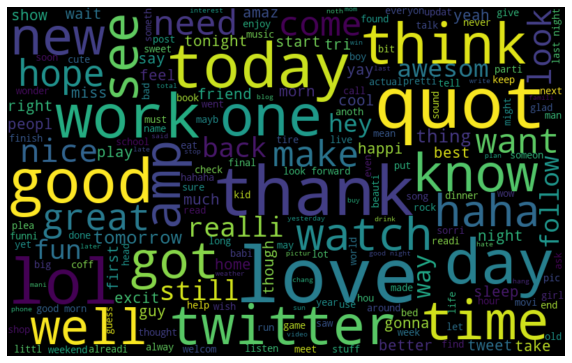

In [41]:
all_words = ' '.join([text for text in data['Clean_TweetText']])

from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

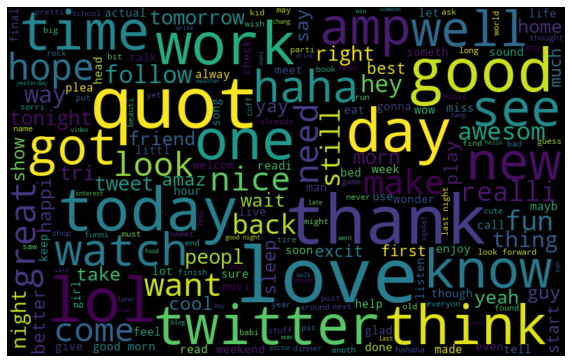

In [42]:
positive_words =' '.join([text for text in data['Clean_TweetText'][data['target'] == 4]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

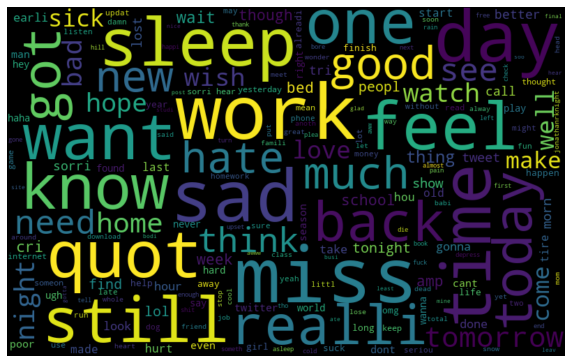

In [43]:
depressive_words =' '.join([text for text in data['Clean_TweetText'][data['target'] == 0]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(depressive_words)

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [44]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [45]:
count_vectorizer = CountVectorizer(stop_words='english') 
cv = count_vectorizer.fit_transform(data['Clean_TweetText'])
cv.shape

(26000, 28660)

In [46]:
X_train,X_test,y_train,y_test = train_test_split(cv,data['target'] , test_size=.2,stratify=data['target'], random_state=42)

In [47]:
rf = RandomForestClassifier(n_estimators=10, random_state=10)
rf.fit(X_train,y_train)
prediction_rf = rf.predict(X_test)
print(accuracy_score(prediction_rf,y_test))

0.9592307692307692


In [48]:
svc = svm.SVC()
svc.fit(X_train,y_train)
prediction_svc = svc.predict(X_test)
print(accuracy_score(prediction_svc,y_test))

0.9615384615384616


In [49]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
prediction_lr = lr.predict(X_test)
print(accuracy_score(prediction_lr,y_test))

0.9621153846153846


In [72]:
pm = process_message('Lately I have been feeling unsure of myself as a person and an artist')
sc_tf_idf.classify(pm)

True

In [73]:
pm = process_message('Extreme sadness, lack of energy, hopelessness')
sc_tf_idf.classify(pm)

True

In [74]:
pm = process_message('Hi hello depression and anxiety are the worst')
sc_tf_idf.classify(pm)

True

In [77]:
pm = process_message('I suffer')
sc_tf_idf.classify(pm)


True

In [78]:
pm = process_message('Feeling down...')
sc_tf_idf.classify(pm)

True

In [79]:
pm = process_message('My depression will not let me work out')
sc_tf_idf.classify(pm)

True

In [80]:
pm = process_message('Hating how me and my partner is talking about what we do not want.')
sc_tf_idf.classify(pm)

False

In [81]:
pm = process_message('Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits')
sc_tf_idf.classify(pm)

False

In [82]:
pm = process_message('it feels disheartening when a patient disparages you for being their doctor')
sc_tf_idf.classify(pm)

False

In [83]:
pm = process_message('Happy Thursday everyone. Thought today was Wednesday so super happy tomorrow is Friday yayyyyy')
sc_tf_idf.classify(pm)

False

In [84]:
pm = process_message('It’s the little things that make me smile. Got our new car today and this arrived with it')
sc_tf_idf.classify(pm)

False

In [85]:
pm = process_message('Hi hello depression and anxiety are the worst')
sc_bow.classify(pm)

True

In [86]:
pm = process_message('My depression will not let me work out')
sc_bow.classify(pm)

True

In [87]:
pm = process_message('Feeling down...')
sc_bow.classify(pm)

False

In [88]:
pm = process_message('Loving how me and my lovely partner is talking about what we want.')
sc_bow.classify(pm)

False

In [89]:
pm = process_message('Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits')
sc_bow.classify(pm)

False

In [90]:
pm = process_message('Happy Thursday everyone. Thought today was Wednesday so super happy tomorrow is Friday yayyyyy')
sc_bow.classify(pm)

False